# NIFITS: application to LBTI nulling

## Perimeter
This work serves as a an exploration proof of concept to demonstrate how NIFITS models can operate at the frontier between continuous and discrete pupils, using the subaperture modelling.

## Tools
We import different modules to help in the managing of different data.

* `xaosim` can be used to create some synthetic pupils. Here, the LBTI pupil will be used instead.
* `xara` and `saro` are kernel-phase data analysis packages meant for the analysis of continuous/arbitrary pupils.
  We will use them to create discrete sub-aperture arrays, based on pupil mask definition.
* `PIL` PILLOW is used to load the png initial image used as a reference pupil and later converted to numpy array.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it.
from IPython.core.display import HTML
css_file = '/home/romain/Downloads/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())



In [2]:
import xaosim
from tqdm import tqdm

In [3]:
import xara
import saro
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as units

### Creation of the LBT pupil map
The pupil map is created based on data provided by the consortium. It was built for the example and should not serve as reference.

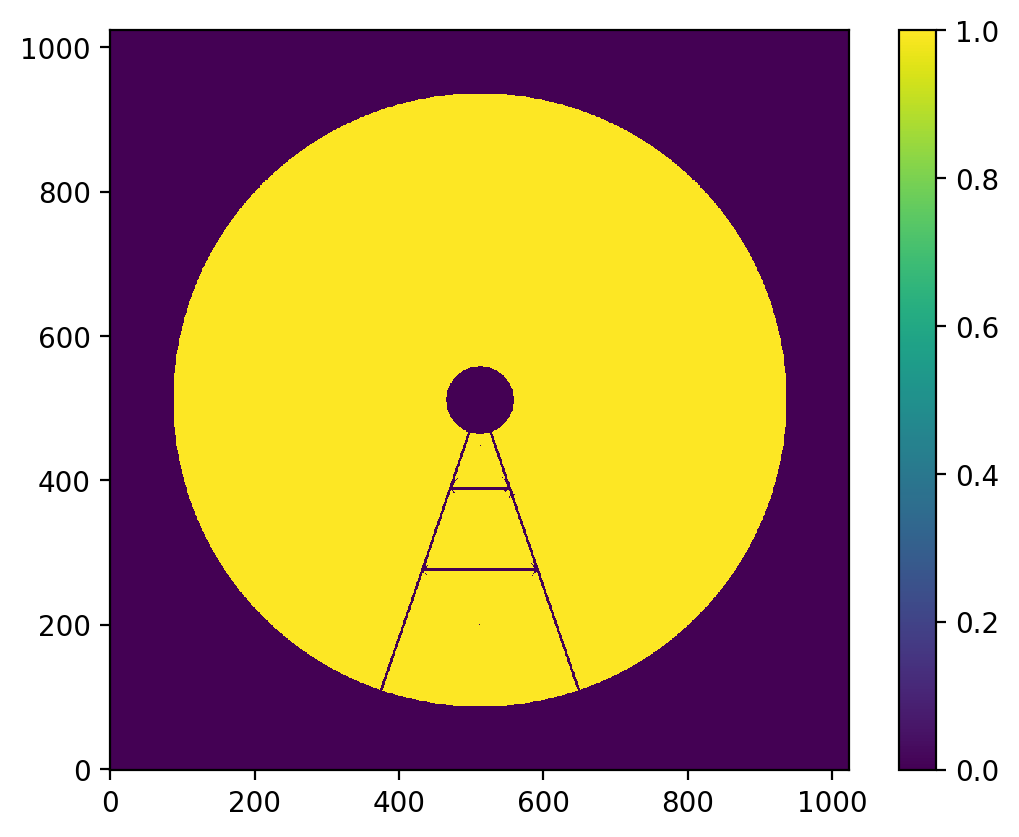

In [4]:
from PIL import Image
# 1024x1024 pix, 0.009732 m/pix
bitmap_lbt = Image.open("lbti_data/bitmap_lbt_pupil.png")
apup = np.flip(np.asarray(bitmap_lbt)[:,:,0]>=1, axis=0)
plt.figure(dpi=200)
plt.imshow(apup[:,:])
plt.colorbar()

### The binocular pupil
A model of the full Fizeau pupil is created as it is used to collect photons. Here, we simplify the operation by using integer pixel shift, which afords a precision of ~10mm. This is sufficient for the sake of the demo, but in practice, one should take care of making this operation more accurate, e.g. by choosing a pixel size that makes this operation correct, or by using a frequency space shift.

In [5]:
# apup = xaosim.pupil.four_spider_mask(500, 500, 200, 8.4, 1.1, beta=50.,thick=0.2, offset=0.3)
ppscale = 0.009732 # m/pix
bpup = np.pad(apup, (800))
cpup = np.roll(bpup, int(np.round((14.4/2/ppscale)))) + np.roll(bpup, int(np.round(-14.4/2/ppscale)))

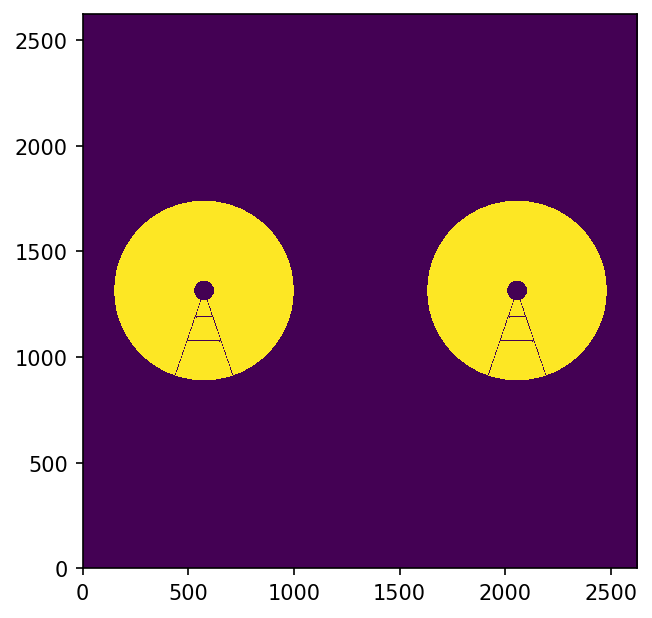

In [6]:
plt.figure(dpi=150)
plt.imshow(1*cpup)
plt.show()

### Discrete model creation
A disccrete array is created based on this high resolution mask. This operation follows the recommendations given by Martinache 2019 for the improved accuracy of such models. The scipt `create_discrete_model` rovided in xara. This takes in 
* a model pitch size `step`,
* the pupil pixel scale `ppscale` in m/pix,
* `binary` which dictate whether to enable the use of partially trasmitting subapertures,
* `tmin` which gives a threshold to discard the subapertures having the lowest transmission.

This returns `model`, an array of x, y and transmission for each subaperture.

The created model is stored into a `kpo.kpi` object for pure convenience. `kpi` has a plotting method to plot the pupil and UV map.

For the `subap_pitch`, it is mandatory to satisfy $\frac{\lambda}{2b}\geq \rho_{max}$ where $\rho_{max}$ is the fov radius. It is recommended to us a pitch that is an integer fraction of the baseline.

In [16]:
subap_pitch = 0.72016 # 0.480112 # 0.72016
model = xara.create_discrete_model(apert=cpup,step=subap_pitch, #0.30
                                ppscale=ppscale, binary=False, tmin=0.02)

Attempting to build KPI from array
644 distinct baselines were identified
first 10 singular values for this array:
[94.41401 88.65738 88.30227 26.67271 26.23008 24.76632 24.56749 24.12401
 23.57307 19.72942]
<xara.kpi.KPI object at 0x7fd2df7bbcd0> KPI data structure
----------------------------------------
-> 242 sub-apertures
-> 644 distinct baselines
-> 403 Ker-phases ( 62.6 % target phase)
-> 241 Eig-phases (100.0 % wavefront phase)
----------------------------------------

KPI data successfully created
No KPO data included
<saro.saro.KPO object at 0x7fd2df96e8e0> deleted
<xara.kpi.KPI object at 0x7fd2df96ea60> deleted 


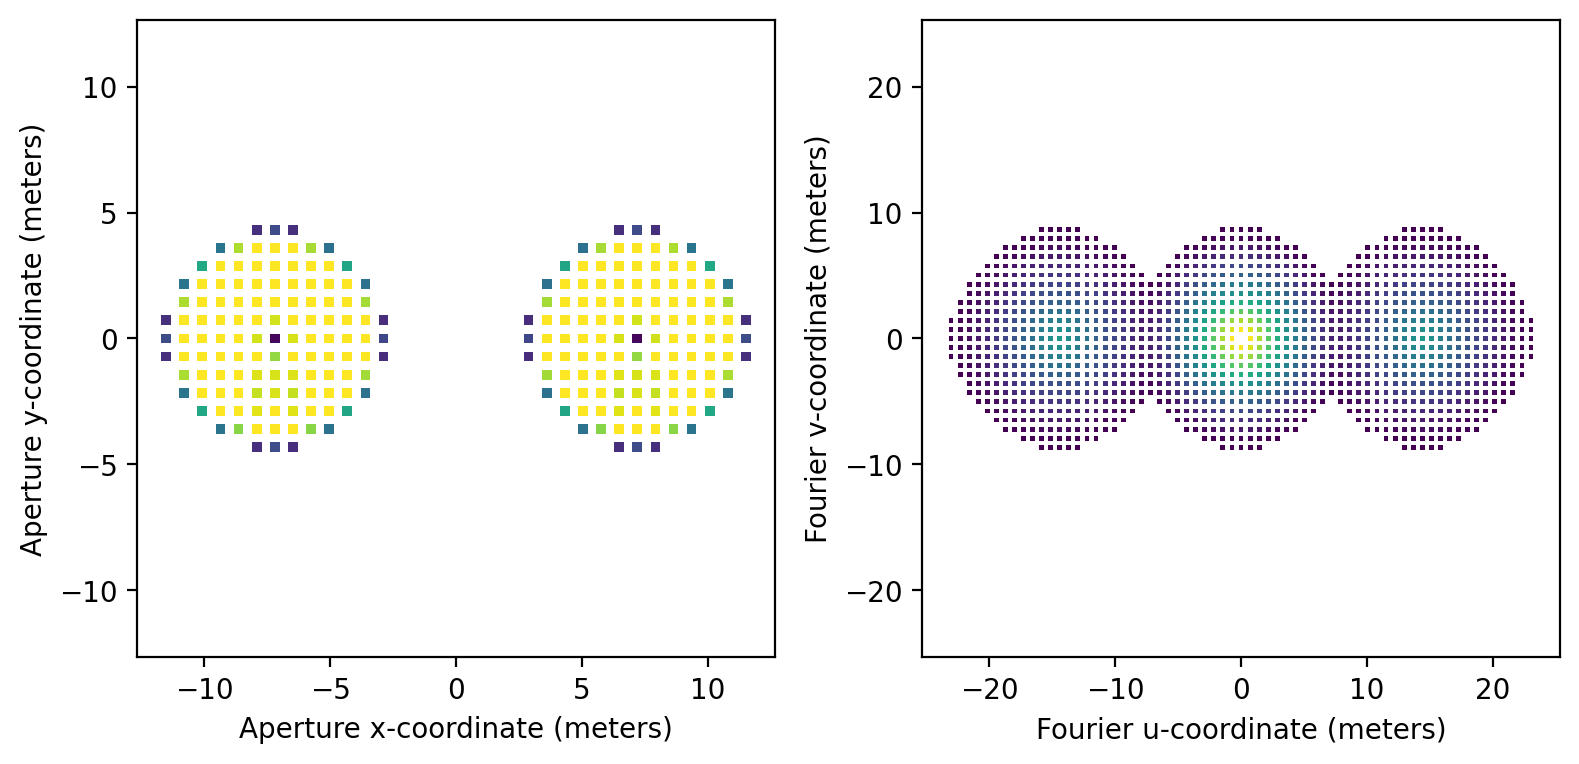

In [17]:
mykpo = saro.KPO(array=model, )
mykpo.CWAVEL = 10.0e-6
dump = mykpo.kpi.plot_pupil_and_uv(cmap="viridis", usesize=False, ssize=3.5, marker="s")
collectors = mykpo.kpi.VAC

![title](nomic_principle.png)

### Nature of the pupil
Here, the interferometric baseline of 14.4 m is not much larger than the diameter of 8.25 m of each aperture. This means that the resolving power of each collector is close to that of the array, and **accounting for the diffraction of in each collector is important in transfer function of the instrument.** We can even see that some of the baselines present between the pupils are already present inside a single pupil.

## Construction of the transfer model

NIFITS relies on an algebraic representation of the interferometer in which the light combination is obtained by taking the vector of complex electric field collected at the inputs, multiplying each element by a complex phasor (to represent possible modulations) and multiplying that vector by a complex matrix $\mathbf{M}_{CATM}$ to obtain the complex amplitude present on the detector.

$$\mathbf{e}_{collected} = \mathbf{c}(x,y,\lambda) \circ \mathbf{e} \tag{1} $$

In LBTI/NOMIC, the beam combination is done by a bulk-optics. The two pupils are relatively phased by $\pi/2$ with an optical delay, then are superimposed with a beamsplitter.

![Schematic of the NOMIC combiner](nomic_principle.png)
### Fig 1.: The NOMIC beam combiner (Defrere et al. 2016)

In order to leverage the full sensitivity, the combined pupil is focused onto the detector. It has traits of different types of beam-combiners:
* Michelson (/Mach-Zehnder) recombination of individual beams since the pupils are superimposed,
* Fizeau recombination as the sub-apertures of each beam are interfered through Fraunhofer interference.
* pupil-remapping Fizeau (multiaxial) beam-combiner.

This last description is better describing the operation. This can be modeled by a direct Fraunhofer propagation of a new pupil which is composed of the two initial pupils superimposed on top of one another. The superimposed pupil `U` can be created based ont he initial array `collectors` as follows:

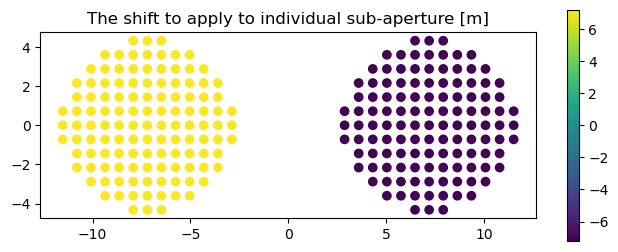

In [18]:
pmask_right = collectors[:,0]>=0
U_shift = np.zeros_like(collectors[:,:2])
U_shift[pmask_right] += np.array((-14.4/2, 0.))
U_shift[np.logical_not(pmask_right)] += np.array((+14.4/2, 0.))
U = collectors[:,:2] + U_shift

plt.figure(figsize=(8,3))
plt.scatter(collectors[:,0], collectors[:,1], c=U_shift[:,0])
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The shift to apply to individual sub-aperture [m]")
plt.show()

## Phase-shifting

Here, a achromatic phase shifting vector `cpx_mask` is created.

In [19]:
def interval_centers(start, end, number):
    """
    Convenience function for more accurate samples on an continuous interval

    * start : start of the interval
    * end : of the interval
    * number : the number of samples
    """
    a0 = np.linspace(start, end, number+1)
    a = np.array([(a0[i] + a0[i+1])/2 for i in range(number)])
    da = np.array([(a0[i+1] - a0[i])/2 for i in range(number)])
    return a, da

## Chromaticity of phase term

From Hinz 2009

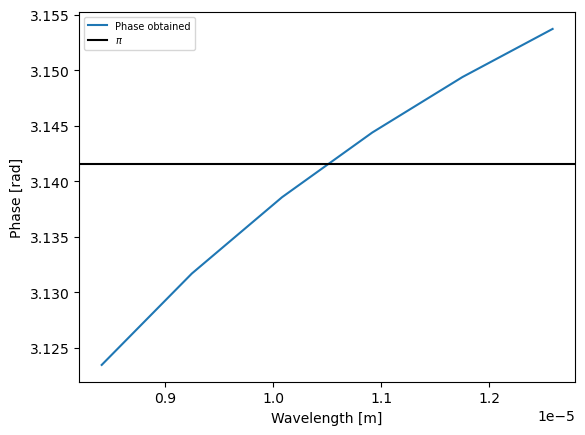

In [20]:
lambs, dlambs = interval_centers(8.0e-6, 13.0e-6, 6)

def get_n_lamb_znse(lamb):
    return 2.4555 - 0.00623*lamb*1e6
thickness = 42.0e-6 #  40.15e-6
phi = 2*np.pi * (1/4) + 2*np.pi/lambs*(np.mean(lambs)*1/4 + (get_n_lamb_znse(np.mean(lambs)) - get_n_lamb_znse(lambs))*thickness)
plt.figure()
plt.plot(lambs, phi, label="Phase obtained")
plt.axhline(np.pi, color="k", label=f"$\\pi$")
plt.ylabel("Phase [rad]")
plt.xlabel("Wavelength [m]")
plt.legend(fontsize=7)
plt.show()

###########################################
# NI_MOD ->  cpix_mask
###########################################
cpx_mask = np.ones((lambs.shape[0], collectors.shape[0]), dtype=np.complex64)
cpx_mask[:,pmask_right] = np.exp(1j*(np.pi/2 + 2*np.pi*(lambs.mean()/4)/lambs[:,None]))
cpx_mask[:,pmask_right] = np.exp(1j*phi[:,None])

## Beam-combination matrix
The Fraunhoffer diffraction boils down to a Fourier transform. Discrete Fourier transforms can be computed with different recipes. A convenient one was proposed by 
A matrix operation for the beam-combination operation is described by [Soummer 2007](https://ui.adsabs.harvard.edu/link_gateway/2007OExpr..1515935S/doi:10.1364/OE.15.015935) using a pair of matrices $\mathbf{E}_1$ and $\mathbf{E}_2$ multiplied on either side of the 2D data $\mathbf{f}$.
$$\mathbf{F} = \mathbf{E}_1 \cdot \mathbf{f} \cdot \mathbf{E}_2 \tag{2}$$
Here each matrix conveniently operates the Fourier transform along one of the axes of the data array. It exploits the fact the Fourier transform is *separable* to do the operation in two steps.

If we so-desire, the operation can be done in a single step, with a single matrix. For this, the data is flattened into a long vector, and a single matrix is written in the fashion of (10) and (11) of Soummer 2007 using both coordinates.

## Normalization and units

The normalization is made so that we give at the each subaperture a collected complex amplitude ($\sqrt{t_r IdXdY}$ with $t_r$ the transmission), and the output will give the complex amplitde corresponding to the flux collected by the given pixel.

The coefficient $\frac{m}{N_A N_B}$ is replaced by $\frac{\sqrt{dxdy}}{\lambda f}$ where $f$ is the focal length and $dx$ and $dy$ are the pixel dimension.

In [21]:
def get_single_matrix_FT(U, X, lamb, f, sign=-1, dU=None, dX=None, dSs=None):
    """
    **Arguments** :
    U         : 2D coordinates in the starting plane
    X         : 2D coordinates in the arrival plane
    lamb      : The wavelength
    f         : The focal length of the system [m]
    """
    i2pi = 1j*2*np.pi
    # Computing the scaling coefficient
    # coeff = 1/(U.shape[0]*X.shape[0])
    # This does not work well. Better give a value
    # if dU is None:
    #     dU = np.min(np.gradient(U[:,1]))
    #     dV = np.min(np.gradient(U[:,0]))
    # if dX is None:
    #     dX = np.mean(np.gradient(X[:,1]))
    #     dY = np.mean(np.gradient(X[:,0]))
    dY = dX
    dV = dU
    # coeff = np.sqrt(dX*dY)/(1j*lamb*f)
    coeff = np.sqrt(dU*dV)/(1j*lamb*f)
    loc_term = np.exp((i2pi/lamb)/(2*f)*np.sqrt(np.sum(X**2, axis=1)))

    X_angle = 1/f*X
    Z = np.einsum("P d, i d -> P i", U, X_angle).T
    # Z = np.outer(U.T, X)
    Z.shape
    C = coeff*np.exp(sign*i2pi/lamb * Z)
    C = loc_term[:,None]*(C)
    if dSs is not None:
        C = np.sqrt(dSs[None,:]/(dU*dV)) * C
    return C

def get_dual_matrix_FT(U, X, lamb, sign=-1):
    """
    **Arguments** :
    U         : 2D coordinates in the starting plane
    X         : 2D coordinates in the arrival plane
    f         : The focal length of the system [m]
    """
    i2pi = 1j*2*np.pi
    
    coeff = 1/(U.size*X.shape[0]*u.shape[1])
    Z0 = U[:,0].outer(X[0,:,0])
    Z1 = U[:,1].outer(X[:,0,1])
    # Z = np.outer(U.T, X)
    Z.shape
    C0 = coeff*np.exp(sign*i2pi/lamb * Z0)
    C0 = coeff*np.exp(sign*i2pi/lamb * Z1)
    return C

## Testing the algorithm


In [22]:
test_norm = False
if test_norm:
    steps = np.linspace(0.4, 0.5, 5)
    dump_imsz = 8.08e-4
    dumpres = 61
    dump_pixpitch = dump_imsz/dumpres # 8e-6
    dumpf = 59.
    dump_fluxdens = 1.
    maxs = []
    col_pow = []
    tot_out =[]
    for astep in tqdm(steps):
        dumpmodel = xara.create_discrete_model(apert=cpup,step=astep, #0.30
                                        ppscale=ppscale, binary=False, tmin=0.001)
        dumpkpo = saro.KPO(array=dumpmodel, )
        dumpkpo.CWAVEL = 10.0e-6
        dump = dumpkpo.kpi.plot_pupil_and_uv(cmap="viridis", usesize=False, ssize=4., marker="s")
        dumpU = dumpkpo.kpi.VAC[:,:2]
        halfwidth = dump_pixpitch*dumpres/2
        xx, yy = np.meshgrid(np.linspace(-halfwidth, halfwidth, dumpres), np.linspace(-halfwidth, halfwidth, dumpres))
        dumpsurfs = astep**2 * dumpkpo.kpi.VAC[:,2]
        dumpdS = dumpsurfs
        dumpX = np.concatenate((xx.flatten()[:,None], yy.flatten()[:,None]), axis=1)
        dumpC = get_single_matrix_FT(dumpU, dumpX, lamb=10e-6, f=dumpf, sign=-1, dU=astep, dX=dump_pixpitch, dSs=dumpdS)
        
        # dumpx  = np.sqrt(dump_fluxdens * dumpdS)
        dumpx = np.sqrt(dump_fluxdens * astep**2)* np.ones_like(dumpdS)
        col_pow.append(dumpsurfs.sum()) # np.abs(dumpx).sum())
        dumpy = dumpC.dot(dumpx)
        dumpIs = np.abs(dumpy)**2
        maxs.append(np.max(dumpIs))
        tot_out.append(np.sum(dumpIs*dump_pixpitch**2))
        plt.figure()
        plt.imshow(np.log10(dumpIs.reshape(xx.shape)))
        plt.colorbar()
        plt.show()
    maxs = np.array(maxs)
    tot_out = np.array(tot_out)
    col_pow = np.array(col_pow)
    tot_out = np.array(tot_out)


In [23]:
if test_norm:
    plt.figure()
    plt.plot(steps,maxs)
    plt.title("maxs")
    plt.show()
    
    plt.figure()
    plt.plot(steps,tot_out)
    plt.title("tot_out")
    plt.show()
    
    plt.figure()
    plt.plot(steps,col_pow)
    plt.title("col_pow")
    plt.show()

In [24]:
if test_norm:
    dump_pupstep = 0.5
    steps = 41 + 4*np.arange(20)
    dump_imsz = 8.08e-4
    dump_fluxdens = 1.
    # dumpres = 81
    dumpf = 59.
    maxs = []
    col_pow = []
    tot_out =[]
    for astep in tqdm(steps):
        dumpres = astep
        dump_pixpitch = dump_imsz/dumpres # 8e-6
        dumpmodel = xara.create_discrete_model(apert=cpup,step=dump_pupstep, #0.30
                                        ppscale=ppscale, binary=False, tmin=0.001)
        dumpkpo = saro.KPO(array=dumpmodel, )
        dumpkpo.CWAVEL = 10.0e-6
        dump = dumpkpo.kpi.plot_pupil_and_uv(cmap="viridis", usesize=False, ssize=4., marker="s")
        dumpU = dumpkpo.kpi.VAC[:,:2]
        halfwidth = dump_pixpitch*dumpres/2
        xx, yy = np.meshgrid(np.linspace(-halfwidth, halfwidth, dumpres), np.linspace(-halfwidth, halfwidth, dumpres))
        dumpsurfs = dump_pupstep**2 * dumpkpo.kpi.VAC[:,2]
        dumpdS = dumpsurfs
        dumpX = np.concatenate((xx.flatten()[:,None], yy.flatten()[:,None]), axis=1)
        dumpC = get_single_matrix_FT(dumpU, dumpX, lamb=10e-6, f=dumpf, sign=-1, dU=dump_pupstep, dX=dump_pixpitch, dSs=dumpdS)
        
        # dumpx  = np.sqrt(dump_fluxdens * dumpdS)
        dumpx = np.sqrt(dump_fluxdens * dump_pupstep**2)* np.ones_like(dumpdS)
        col_pow.append(dumpsurfs.sum()) # np.abs(dumpx).sum())
        dumpy = dumpC.dot(dumpx)
        dumpIs = np.abs(dumpy)**2
        maxs.append(np.max(dumpIs))
        tot_out.append(np.sum(dumpIs*dump_pixpitch**2))
        plt.figure()
        plt.imshow(np.log10(dumpIs.reshape(xx.shape)))
        plt.colorbar()
        plt.show()
    maxs = np.array(maxs)
    tot_out = np.array(tot_out)
    col_pow = np.array(col_pow)
    tot_out = np.array(tot_out)


In [25]:
if test_norm:
    plt.figure()
    plt.plot(steps,maxs)
    plt.title("maxs")
    plt.show()
    
    plt.figure()
    plt.plot(steps,tot_out)
    plt.title("tot_out")
    plt.show()
    
    plt.figure()
    plt.plot(steps,col_pow)
    plt.title("col_pow")
    plt.show()

## Numerical application:
Here, we bypass the beam-compression operation that is done before entering the instrument, using the size of the initial pupil and the equivalent total focal length. Here we assume an approximate focal length of 50m and a pixel pitch of 50µm. We compute an array of 100x100 pixels.

The plate scale is 18mas/pix (Defrere et al 2016).

### For the annuli:

```Le premier rayon considéré est pour la HWHM de la PSF des télescopes (donc 0.5 lambda/D avec lambda=11µm et D=8.4m). Ca donne un rayon de 140mas ce qui correspond à 8pix (1pix=17.5mas). Les autres rayons sont choisis arbitrairement à 13,19,26 et 34 pixels```

0.0001775


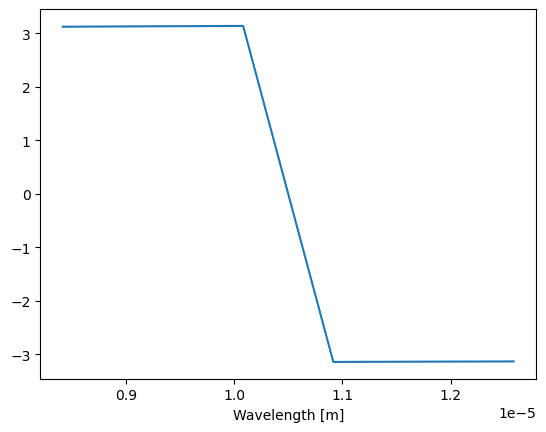

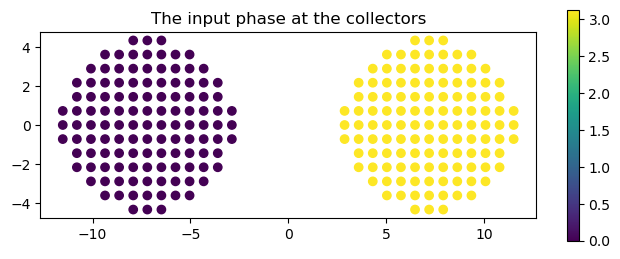

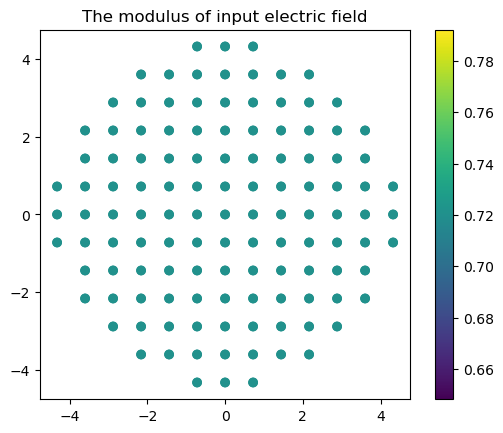

In [26]:
fluxdens = 1.
res = 71
pixel_pitch = 5.0e-6 # [m]
halfwidth = pixel_pitch*res/2
pixel_angular_pitch = 17.5 # [mas] 18 mas /pix from Defrere 2016
f = pixel_pitch/(pixel_angular_pitch*units.mas.to(units.rad))
det_extent = [-halfwidth, halfwidth, -halfwidth, halfwidth]
print(halfwidth)
xx, yy = np.meshgrid(np.linspace(-halfwidth, halfwidth, res), np.linspace(-halfwidth, halfwidth, res))
X = np.concatenate((xx.flatten()[:,None], yy.flatten()[:,None]), axis=1)

dS = subap_pitch**2 * mykpo.kpi.VAC[:,2] # Unknown to the user ()

C = np.array([get_single_matrix_FT(U, X, lamb=alamb, f=f, sign=-1, dU=subap_pitch, dX=pixel_pitch, dSs=dS) for alamb in lambs])
C = (C).astype(np.complex64)
# x = np.sqrt(np.outer(np.ones_like(lambs).T,collectors[:,2])) / tot_amp
x = np.ones(collectors.shape[0]) * np.sqrt(np.outer(fluxdens * np.ones_like(lambs).T, subap_pitch**2)) 
# g = C.dot(x)

rhos = np.sqrt(xx**2+yy**2)
# radii = 50e-6*np.arange(6)
radii = pixel_pitch * 1/pixel_angular_pitch * np.array([-0.1, 140, 13*pixel_angular_pitch, 19*pixel_angular_pitch, 26*pixel_angular_pitch, 34*pixel_angular_pitch])
radii = np.nan_to_num(radii)
K = np.array([(rhos>radii[i])*(rhos<radii[i+1]) for i in range(len(radii)-1)]).astype(np.float32)
Kflat = K.reshape(K.shape[0], -1)



def dot_all_wl(C, x):
    return np.einsum("w o i , w i -> w o", C, x)
    

phased_one = np.argwhere(pmask_right)[0,0]
plt.figure()
plt.plot(lambs, np.angle(cpx_mask[:,phased_one]))
plt.xlabel("Wavelength [m]")
plt.show()

plt.figure(figsize=(8,3))
plt.scatter(collectors[:,0], collectors[:,1], c=np.angle(cpx_mask[0,:]))
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The input phase at the collectors")
plt.show()

plt.figure()
plt.scatter(U[:,0], U[:,1], c=np.abs(x[0]))
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The modulus of input electric field")
plt.show()



### At this stage, the result is adimensional
$ph.s^{-1}.m^{-2}$ per spectral channel for 1 $ ph.s^{-1}.m^{-2}$ per spcectral channel at the pupil. So it is a light concentration factor.
To obtain ph/s per pixel per spectral channel, you need to multiply by the pixel surface i.e. `pix_pitch**2`.

<div class="alert alert-block alert-warning">
<b>TODO:</b> factor this into C?
</div>

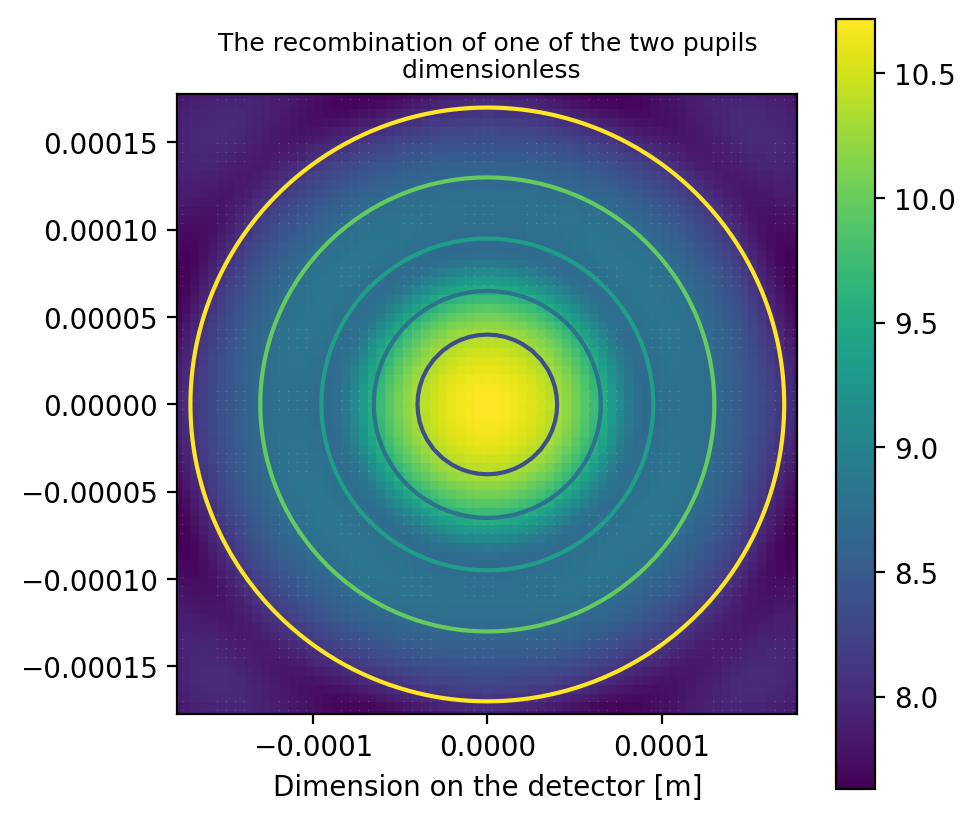

In [27]:
# g1 = C[0][:,pmask_right].dot(x[pmask_right])
g1 = dot_all_wl(C[:,:,pmask_right], x[:,pmask_right])
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.sum(np.abs(g1)**2, axis=0)), s=7., marker="s")
plt.colorbar()
plt.contour(rhos, levels=radii, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
plt.gca().set_aspect("equal")
plt.xlabel("Dimension on the detector [m]")
plt.title("The recombination of one of the two pupils\n dimensionless", fontsize=9)
plt.show()

47176924632660.414


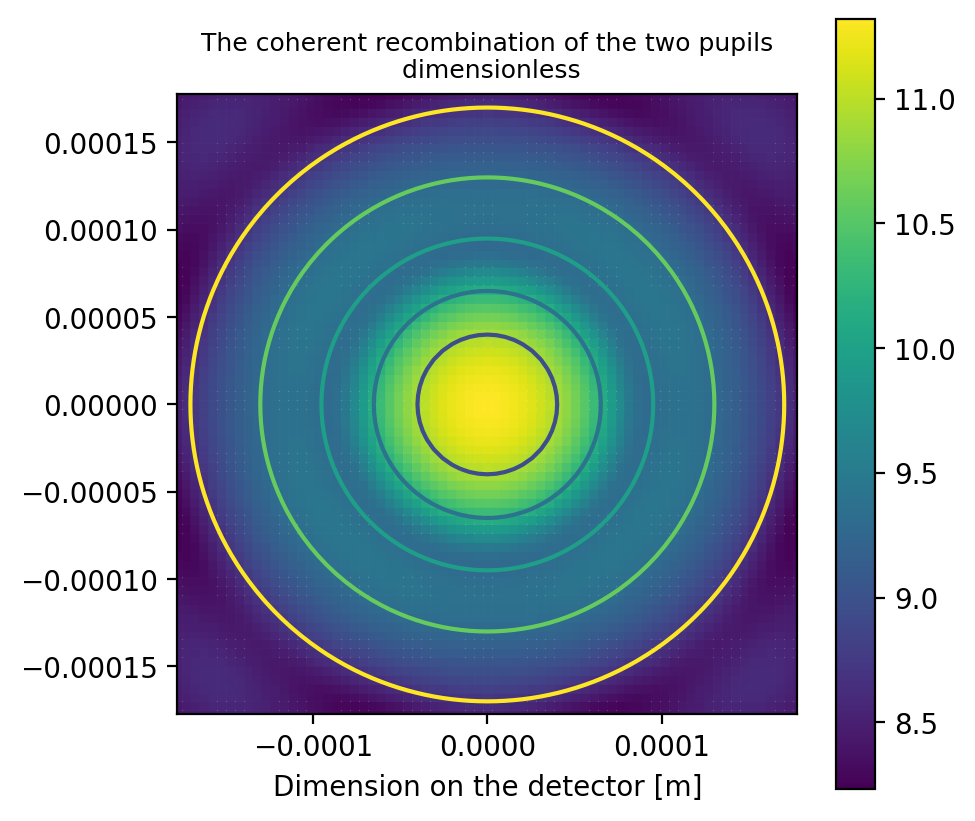

In [28]:
# g2 = C.dot(x)
g2 = dot_all_wl(C, x)
print(np.sum(np.abs(g2**2)))
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.sum(np.abs(g2)**2, axis=0)), s=7., marker="s")
plt.colorbar()
plt.contour(rhos, levels=radii, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
plt.gca().set_aspect("equal")
plt.xlabel("Dimension on the detector [m]")
plt.title("The coherent recombination of the two pupils\n dimensionless", fontsize=9)
plt.show()

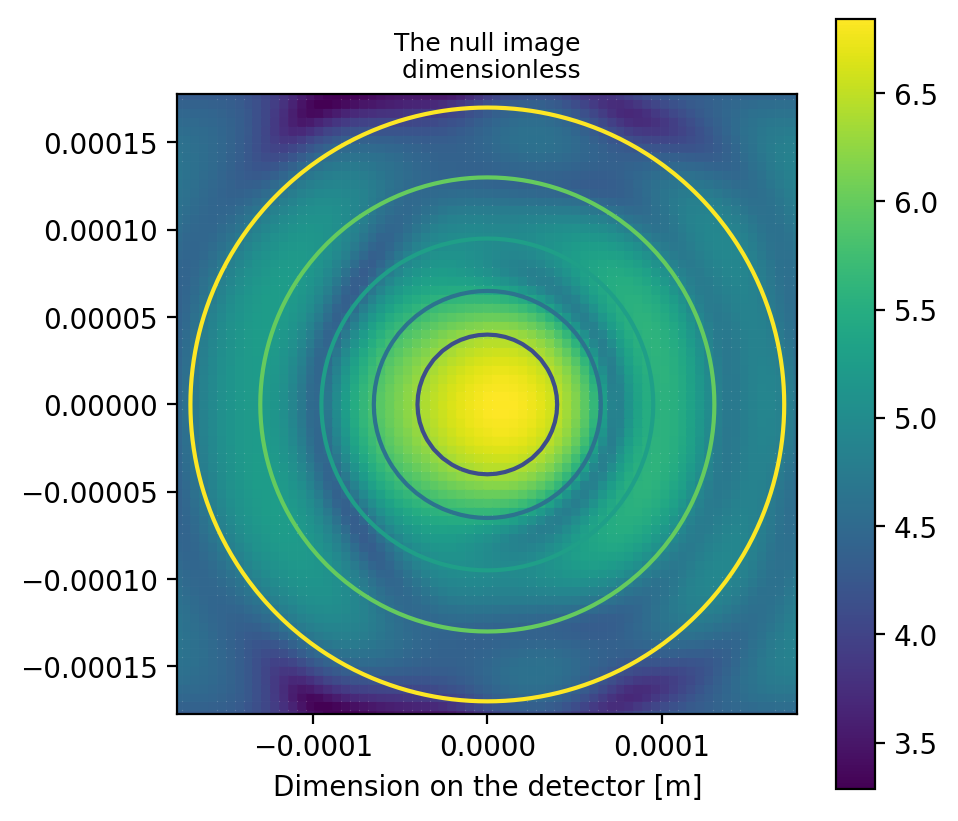

In [29]:
# gn = C.dot(x * cpx_mask.T)
gn = dot_all_wl(C, x * cpx_mask)
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.sum(np.abs(gn)**2, axis=0)), s=7., marker="s")
plt.colorbar()
plt.contour(rhos, levels=radii, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
plt.gca().set_aspect("equal")
plt.xlabel("Dimension on the detector [m]")
plt.title("The null image\n dimensionless", fontsize=9)
plt.show()

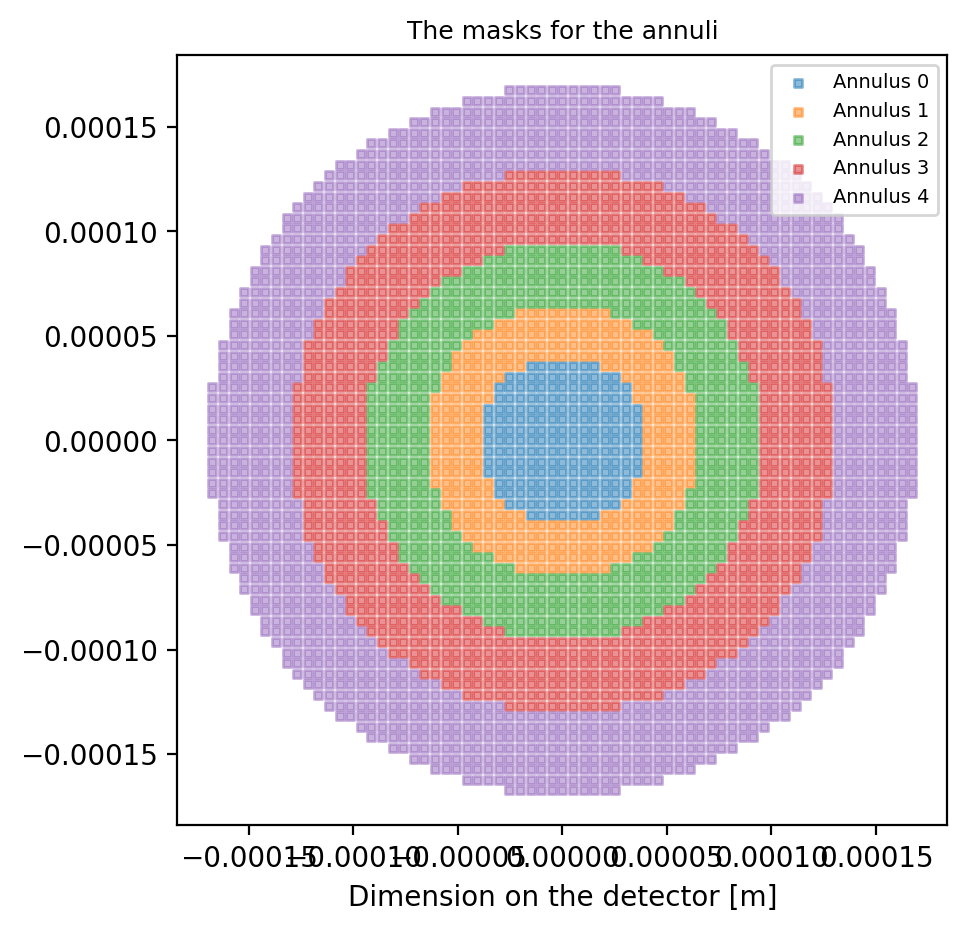

In [30]:
# gn = C.dot(x * cpx_mask.T)
gn = dot_all_wl(C, x * cpx_mask)
plt.figure(dpi=200, figsize=(5,5))
for i, akflat in enumerate(Kflat):
    plt.scatter(xx.flatten()[akflat>0], yy.flatten()[akflat>0], s=7., marker="s", alpha=0.5,
               label=f"Annulus {i}")
# plt.colorbar()
# plt.contour(rhos, levels=radii, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
plt.gca().set_aspect("equal")
plt.legend(fontsize=7)
plt.xlabel("Dimension on the detector [m]")
plt.title("The masks for the annuli", fontsize=9)
plt.show()

#### Null leakage

Here, we can see that some leakage is present. It seems to come from the inperfect alignment of the pupils we created, due to the integer pixel shifting of the pupil images. We can estimate the resulting null depth:

In [31]:
null_depth = np.sum(np.abs(gn)**2)/np.sum(np.abs(g2)**2)
print(f"{null_depth:.4e}")

3.2861e-05


## Size considerations
With this type of computation, the array size can be a significant concern. Here, we switch to single precision complex numbers (`np.complex64`) instead of the default (`np.complex128`). With our operation, we have a matrix which is 53MB. Acouple of of choices can be made:

1. Single precision float (Already implemented)
2. Discard the corners of the array by discarding the relevant rows of the matrix for a gain of $\pi/4$ in size.
3. Revert to a 2 matrix operation. This would change the size from $n_i \times n_o$ into a size of $n_{xi} n_{xo} + n_{yi} n_{yo}$. For the typical square configuration of arrays, that is : $2*(\sqrt{n_i * n_o})$ instead of $n_i* n_o$ in memory.

An alternative is to keep the instrument array is a separate file, which would be shared with many different observation files.

In [32]:
n_i = U.shape[0]
n_o = xx.flatten().shape[0]
print(f"Transfer matrix from {n_i} pupils to {n_o} pixels")

Transfer matrix from 242 pupils to 5041 pixels


In [33]:
print(f"Memory footprint: {C.__sizeof__()/(2**20):.2f} MB with {C.dtype} type")
import timeit

thetime = timeit.timeit("I = dot_all_wl(C,x)", globals=globals(), number=100)
print(thetime)

Memory footprint: 55.84 MB with complex64 type
1.1293998440014548


In [34]:
result = %timeit -o I = dot_all_wl(C,x)

11.4 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Null values
Currently the data reduction pipeline of LBTI extracts aperture photometry of the main spot of the system. This can be obtained usning the K matrix. A matrix can be constructed to sum the values of pixels in different concentric regions. One can use this as the main observables in the interpretation.

In NIFITS we can go further by considering sectors rather than annuli, and start considering the possibility of inclined disks VS face-on disks, or the astrometry of an off-axis source.

## Transmission map

The phasor at the input can be computed as Fourier transform, but it can also b

In [35]:
def geometric_phasor(alpha, beta, anarray, lambs):
    """
    Returns the complex phasor corresponding to the locations
    of the family of sources
    
    **Parameters:**
    
    * alpha         : The coordinate matched to X in the array geometry
    * beta          : The coordinate matched to Y in the array geometry
    * anarray       : The array geometry (n_input, 2)
    
    **Returns** : A vector of complex phasors
    """
    k = 2*np.pi/lambs
    a = np.array((alpha, beta), dtype=np.float64)
    phi = k[:,None,None] * anarray.dot(a)[None,:]
    b = np.exp(1j*phi)
    return b


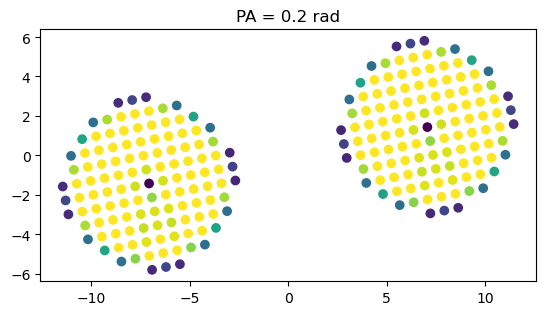

In [36]:

def dot_all_fov(C, xs, K):
    E = np.einsum("w o i , w i m -> w o m", C, xs)
    I = np.abs(E)**2
    kap = np.einsum("w i m, o i -> w o m", I, K[:,:])
    return kap

import dask.array as da
def dot_all_fov_dask(C, xs, K):
    E = np.einsum("w o i , w i m -> w o m", C, xs)
    I = np.abs(E)**2
    kap = np.einsum("w i m, o i -> w o m", I, K[:,:])
    return kap.compute()
    
import astropy.units as units
dcols = np.ones(collectors.shape[0]) * subap_pitch **2 # collecting area element
dpix = pixel_pitch **2
map_fov_mas = 750.
map_res = 127
mas2rad = units.mas.to(units.rad) # in mas
aa, bb = np.meshgrid(np.linspace(-map_fov_mas, map_fov_mas, map_res), np.linspace(-map_fov_mas, map_fov_mas, map_res))

PA = 0.2
R = np.array([[np.cos(PA),-np.sin(PA)],
             [np.sin(PA), np.cos(PA)]])

projected_collectors = np.einsum("o i, p i -> p o", R, collectors[:,:2])
plt.figure()
plt.scatter(projected_collectors[:,0], projected_collectors[:,1], c=collectors[:,2], marker="o")
plt.gca().set_aspect("equal")
plt.title(f"PA = {PA:.1f} rad")
plt.show()


In [37]:
gem_phas = np.sqrt(dcols[None,:,None]) * cpx_mask[:,:,None] * geometric_phasor(mas2rad * aa.flatten(), mas2rad * bb.flatten(), projected_collectors[:,:2], lambs)
gem_phas = gem_phas.reshape((lambs.shape[0], collectors.shape[0], -1))
# %time out_map = np.sum(1/(lambs[:,None,None]*f) * dot_all_fov(C, gem_phas, Kflat), axis=0) # 
dac = da.from_array(C, chunks=1000)
dgem_phas = da.from_array(gem_phas, chunks=1000)
%time out_map = pixel_pitch**2 /lambs.shape[0] * np.sum(1/(lambs[:,None,None]*f) * dot_all_fov_dask(dac, dgem_phas, Kflat), axis=0)

CPU times: user 9min 45s, sys: 26.4 s, total: 10min 12s
Wall time: 42.4 s


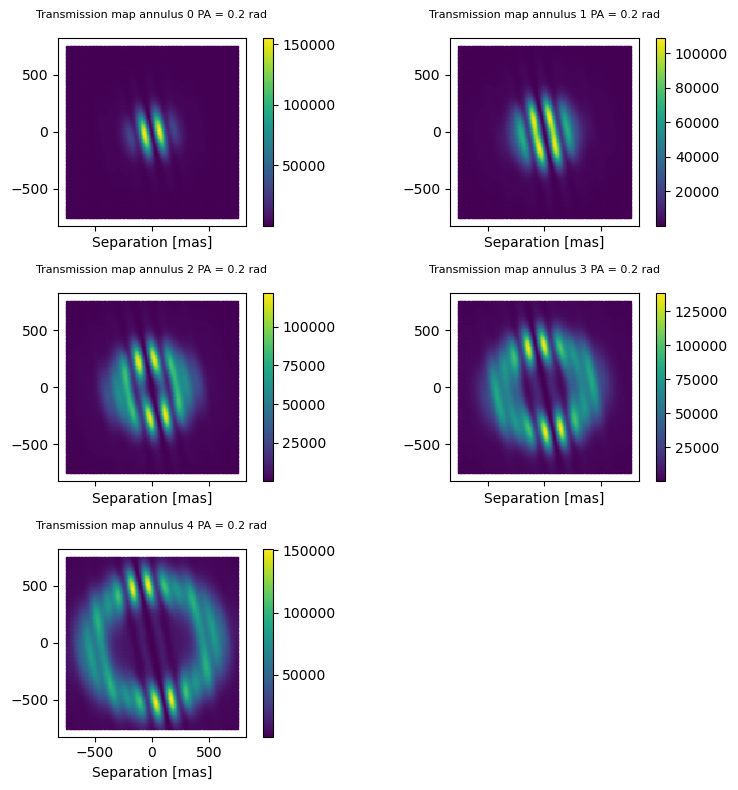

In [40]:
fig, axes = plt.subplots(3,2, figsize=(8,8), dpi=100, sharex="all")
for i, amap in enumerate(out_map):
    plt.sca(axes.flat[i])
    plt.scatter(aa.flatten(), bb.flatten(), c=amap.reshape(*aa.shape), s=0.8, marker="s")
    plt.colorbar()
    plt.gca().set_aspect("equal")
    plt.xlabel("Separation [mas]")
    plt.title(f"Transmission map annulus {i} PA = {PA:.1f} rad\n ", fontsize=8)
i += 1
fig.delaxes(axes.flat[i])
plt.tight_layout()
plt.show()


def get_pupil_shift_matrix(U, shift, mask):
    U[mask] = U[mask]+shift
    return U

In [ ]:
# gn = C.dot(x * cpx_mask.T)
gn = dot_all_wl(C, x * cpx_mask)
plt.figure(dpi=200, figsize=(5,5))
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.sum(np.abs(gn)**2, axis=0)), s=7., marker="s")
plt.colorbar()
plt.contour(rhos, levels=radii, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
plt.gca().set_aspect("equal")
plt.xlabel("Dimension on the detector [m]")
plt.title("The null image", fontsize=9)
plt.show()

In [ ]:
from xaosim.sft import sft

In [ ]:
A0 = np.ones((10,10))
A1 = np.pad(A0, 10, )
print(np.sum(A1) == np.sum(A0))

out1 = sft(A0, 20, 3)
plt.figure()
plt.imshow(np.abs(out))
plt.colorbar()
plt.show()

out2 = sft(A0, 40, 6)
plt.figure()
plt.imshow(np.abs(out2))
plt.colorbar()
plt.show()

out3 = sft(A1, 20, 3)
plt.figure()
plt.imshow(np.abs(out2))
plt.colorbar()
plt.show()

In [ ]:
A0 = np.ones((5,20))
A0 = np.pad(A0, ((12, 13),(5,5)))
plt.imshow(A0)
A1 = np.pad(A0, 10, )
out4 = sft(A0, 20, 8)
plt.figure()
plt.imshow(np.abs(out))
plt.colorbar()
plt.show()

out5 = sft(A0, 40, 16)
plt.figure()
plt.imshow(np.abs(out2))
plt.colorbar()
plt.show()

out6 = sft(A1, 20, 8)
plt.figure()
plt.imshow(np.abs(out2))
plt.colorbar()
plt.show()